## Librarby Import

In [79]:
import pandas as pd
import numpy as np

import pymongo

import matplotlib.pyplot as plt
from matplotlib import pyplot,figure
import seaborn as sns

from sklearn.gaussian_process import kernels,GaussianProcessRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.linear_model import BayesianRidge,Ridge,Lasso,ElasticNet
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder,scale,LabelEncoder,MinMaxScaler

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error
from sklearn.decomposition import PCA

from mlxtend.regressor import StackingRegressor
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from skopt import BayesSearchCV

from skopt.space import Real, Categorical, Integer
from scipy.stats import skew


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Set maximum number of columns to display
pd.set_option('display.max_columns', None)  # None means no limit

# Set maximum width for each column
pd.set_option('display.max_colwidth', None)  # None means no limit

# Set maximum width for the entire DataFrame
pd.set_option('display.width', None)  # None means no limit

In [80]:
# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["stock_data_db"]
collection = db["stock_data"]

# Fetch data from MongoDB
data=collection.find({})

# Convert document based database to pandas dataframe
df = pd.DataFrame(list(data))

# Extract the desired data from the document-converted dataframe
df = pd.DataFrame(df[df['symbol']=='NVDA']['technical_data'][0])

## Check Data Integrity

In [81]:
#Compute the missing value ratio 
missing_data = ((df.isnull().sum())/len(df))
missing_data = missing_data[missing_data.values > 0].sort_values()

if missing_data.empty:
    print('No missing values')    
else:
    #Visualize the missing value ratio 
    fig = plt.figure(figsize=(5,5), dpi = 100)
    sns.barplot(x = missing_data.index, y = missing_data.values) 
    plt.xticks(rotation=90)
    plt.title('Features Missing Ratio')
    plt.show()

No missing values


## Data Processing

In [82]:
# Add Timestamp column
df['timestamp'] = np.array([i for i in range(len(df))])
df = df.set_index('timestamp')
df = df.drop(columns=['date'])

# Convert columns with Alert to category
df["CandleStickType"] = df["CandleStickType"].astype('category')
alert_columns = df.columns[df.columns.str.contains('Alert')]
for column in alert_columns:
    df[column] = df[column].astype('category')

# Normalize the data
scaler = MinMaxScaler()
numeric_df = df.select_dtypes(include=[np.number])
df[numeric_df.columns] = scaler.fit_transform(df[numeric_df.columns])

# One hot encode the categorical columns
categorical_df = df.select_dtypes(include=['category'])
df = pd.get_dummies(df, columns=categorical_df.columns)

df

,open,high,low,close,volume,8EMA,13EMA,144EMA,169EMA,MACD,MACD_SIGNAL,MACD_HIST,atr,BodyDiff,close_t-1,close_t-2,close_t-3,Incremental_High,MACD_GOLDEN_CROSS,169EMA_Upper,169EMA_Lower,CandleStickType_green,CandleStickType_red,MACD_Alert_-1,MACD_Alert_0,MACD_Alert_1,Engulf_Alert_-1,Engulf_Alert_0,Engulf_Alert_1,dual_channel_Alert_-1,dual_channel_Alert_0,dual_channel_Alert_1,382_Alert_0,382_Alert_1
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.016278,0.010949,0.013268,0.010718,0.429679,0.011541,0.013287,0.024527,0.026618,0.276104,0.231796,0.464793,0.019623,5.533665e-02,0.016342,0.015659,0.017314,False,False,0.026618,0.026618,False,True,False,True,False,True,False,False,False,True,False,False,True
1,0.011237,0.006783,0.011864,0.010356,0.360017,0.010182,0.011921,0.023630,0.025759,0.275804,0.231293,0.465156,0.018618,9.536694e-03,0.010718,0.016342,0.015659,False,False,0.025759,0.025759,True,False,False,True,False,True,False,False,False,True,False,True,False
2,0.011788,0.007155,0.011510,0.008042,0.275738,0.008578,0.010395,0.022701,0.024870,0.274831,0.230665,0.463972,0.017560,2.805638e-02,0.010356,0.010718,0.016342,False,False,0.024870,0.024870,False,True,True,False,False,True,False,False,False,True,False,False,True
3,0.011912,0.007751,0.011872,0.009529,0.280470,0.007682,0.009316,0.021813,0.024018,0.275864,0.230402,0.467418,0.016561,9.314920e-03,0.008042,0.010356,0.010718,False,False,0.024018,0.024018,False,True,True,False,False,True,False,False,False,True,False,True,False
4,0.011160,0.008425,0.012661,0.012124,0.272156,0.007598,0.008789,0.020989,0.023221,0.279193,0.230966,0.475205,0.015569,3.504277e-02,0.009529,0.008042,0.010356,False,True,0.023221,0.023221,True,False,True,False,False,False,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.821869,0.845316,0.859968,0.867888,0.144746,0.866459,0.881785,0.991601,0.990329,0.239250,0.217571,0.397385,0.999751,2.541845e-01,0.849874,0.779033,0.765926,True,False,0.990329,0.990329,True,False,True,False,False,True,False,False,True,False,False,True,False
496,0.839257,0.838883,0.878224,0.867566,0.051181,0.877498,0.887952,0.994206,0.993202,0.274741,0.219666,0.489618,0.995363,1.110304e-03,0.867888,0.849874,0.779033,False,True,0.993202,0.993202,True,False,True,False,False,True,False,False,True,False,False,False,True
497,0.821481,0.825087,0.851580,0.848909,0.058750,0.881678,0.890374,0.996409,0.995714,0.290972,0.225117,0.521221,0.990117,9.420481e-07,0.867566,0.867888,0.849874,False,True,0.995714,0.995714,False,True,True,False,False,True,False,False,True,False,False,False,True


## Machine Learning Model

### Base Model

MSE Baseline Score: 0.00020680026


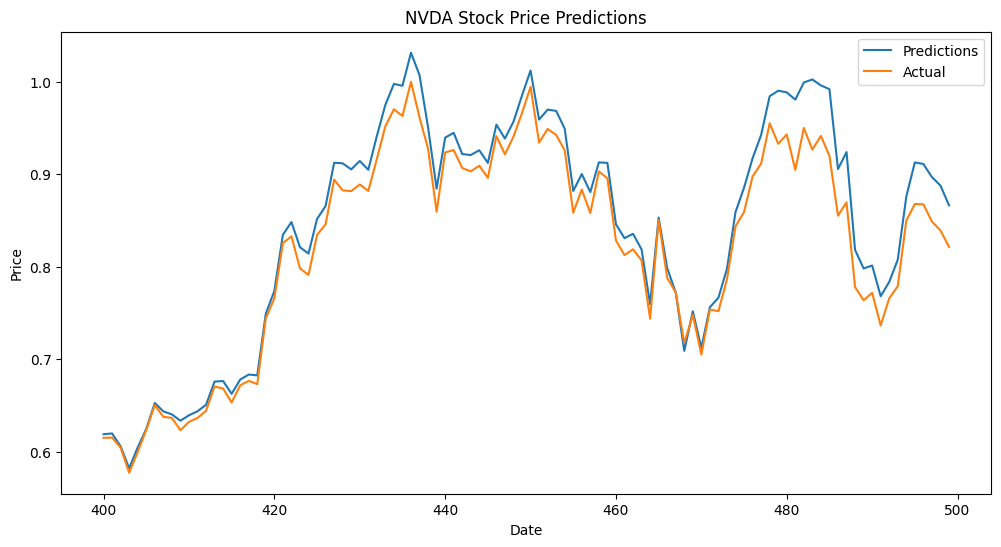

In [88]:
def base_score(df):

    X = df.copy()
    
    # Split data into training and testing sets
    train_size = int(len(df) * 0.8)
    X_train = X[:train_size].drop('close', axis=1)
    y_train_data = df['close'][:train_size]
    X_test = X[train_size:].drop('close', axis=1)
    y_test_data = df['close'][train_size:]
    
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()
    
    # Normalize the data
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    # Log-transform the target variable
    y_train_data = np.log1p(y_train_data)
    y_test_data = np.log1p(y_test_data)
    
    # Train the model
    kernel = kernels.RBF()
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(X_train_normalized, y_train_data)

    # Make predictions on the testing set
    predictions = model.predict(X_test_normalized)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_data, predictions)
    
    # Plot predictions and actual stock prices
    plt.figure(figsize=(12, 6))
    plt.plot(X_test.index, np.expm1(predictions), label='Predictions')
    plt.plot(X_test.index, np.expm1(y_test_data), label='Actual')
    plt.title('NVDA Stock Price Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    return mse

print(f"MSE Baseline Score: {base_score(df):.8}")